# Урок 6. Градиентный бустинг¶

1. Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. 
Сделать выводы о зависимости ошибки от этих параметров.

In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

In [2]:
from sklearn.datasets import load_diabetes
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)


In [3]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [4]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [5]:
def bias(y, z):
    return (y - z)

In [6]:
def gb_fit(n_trees_item, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees_item):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [7]:
def evaluate_train(n_trees_item, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    trees, train_errors, test_errors = gb_fit(n_trees_item, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    return mean_squared_error(y_train, train_prediction)   
    

In [8]:
def evaluate_test(n_trees_item, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    trees, train_errors, test_errors = gb_fit(n_trees_item, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    return mean_squared_error(y_test, test_prediction)   

In [9]:
# Число деревьев в ансамбле
#n_trees = 20

# для простоты примем коэффициенты равными 1
#coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 0.1

In [10]:
def evalute_test_by_trees_count(n_trees_arr, max_depth, X_train, X_test, y_train, y_test, eta):
    errors=[]
    for n_trees_item in n_trees_arr:
        coefs = [1] * n_trees_item
        error=evaluate_test(n_trees_item, max_depth, X_train, X_test, y_train, y_test, coefs, eta)        
        errors.append(error)
    return errors

In [11]:
n_trees_arr=[1,3,5,10,15,20,30,35]
test_errors_arr=evalute_test_by_trees_count(n_trees_arr, max_depth, X_train, X_test, y_train, y_test, eta)
print(test_errors_arr)

[25374.877057584574, 17928.797574165186, 13163.2336480275, 7174.047101481215, 5102.679881289958, 4266.837034026598, 3846.481440725761, 3782.056787030833]


In [12]:
def evalute_train_by_trees_count(n_trees_arr, max_depth, X_train, X_test, y_train, y_test, eta):
    errors=[]
    for n_trees_item in n_trees_arr:
        coefs = [1] * n_trees_item
        error=evaluate_train(n_trees_item, max_depth, X_train, X_test, y_train, y_test, coefs, eta)        
        errors.append(error)
    return errors

In [13]:
train_errors_arr=evalute_train_by_trees_count(n_trees_arr, max_depth, X_train, X_test, y_train, y_test, eta)
print(train_errors_arr)

[23689.315728470992, 16437.76747263488, 11616.689276377074, 5521.308781361178, 3211.646666605541, 2308.6329724539873, 1702.6716648488157, 1549.0659824835184]


In [14]:
import matplotlib.pyplot as plt

In [15]:
def get_error_plot(source_arr,train_errors_arr,test_errors_arr,xlabel_name):
    plt.xlabel(xlabel_name)
    plt.ylabel('MSE')
    plt.xlim(0, max(source_arr))
    plt.plot(source_arr, train_errors_arr, label='train error')
    plt.plot(source_arr, test_errors_arr, label='test error')
    plt.legend(loc='upper right')
    plt.show()

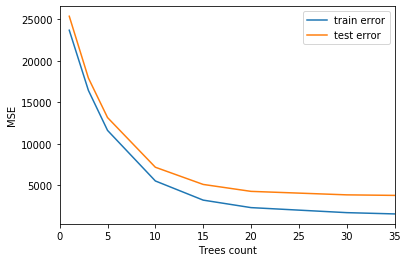

In [16]:
get_error_plot(n_trees_arr,train_errors_arr,test_errors_arr,'Trees count')

Вывод:  видно что при количестве деревьев более чем 30 ошибка выходит на плато и почти не снижается на тесте 
- т.е. есть переобучение модели но маленькое.

In [17]:
def evalute_train_by_tree_max_depth(n_trees, max_depth_arr, X_train, X_test, y_train, y_test, eta):
    coefs = [1] * n_trees
    errors=[]
    for max_depth_item in max_depth_arr:        
        error=evaluate_train(n_trees, max_depth_item, X_train, X_test, y_train, y_test, coefs, eta)        
        errors.append(error)
    return errors

In [18]:
def evalute_test_by_tree_max_depth(n_trees, max_depth_arr, X_train, X_test, y_train, y_test, eta):
    coefs = [1] * n_trees
    errors=[]
    for max_depth_item in max_depth_arr:        
        error=evaluate_test(n_trees, max_depth_item, X_train, X_test, y_train, y_test, coefs, eta)        
        errors.append(error)
    return errors

In [19]:
n_trees=15

In [20]:
max_depth_arr=[1,3,5,10,15]
train_errors_arr=evalute_train_by_tree_max_depth(n_trees, max_depth_arr, X_train, X_test, y_train, y_test, eta)
print(train_errors_arr)

[4340.867532521991, 3211.646666605541, 2203.6645219558177, 1234.7891907049354, 1213.442033668583]


In [21]:
test_errors_arr=evalute_test_by_tree_max_depth(n_trees, max_depth_arr, X_train, X_test, y_train, y_test, eta)
print(test_errors_arr)

[5294.101832565925, 5102.679881289958, 5399.393601297709, 7129.675942505864, 7465.10574096889]


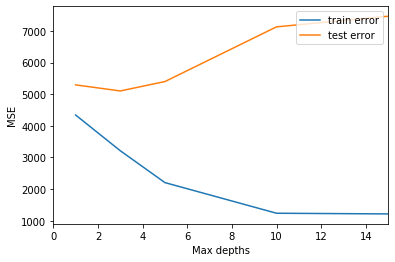

In [22]:
get_error_plot(max_depth_arr,train_errors_arr,test_errors_arr,'Max depths')

Вывод:  видно что при максимальной глубине более чем 3 ошибка увеличивается на тесте 
- т.е. есть переобучение модели

2*. Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. 
    Сравнить на одном графике кривые  изменения ошибки на тестовой выборке в зависимости от  числа итераций.

Его суть заключается в обучении каждого нового базового алгоритма на новой итерации не на всей обучающей выборке, а на некоторой ее случайной подвыборке

In [134]:
import random
random.seed(42)

In [135]:
def get_bootstrapEx(data, N, subsample_size):
    n_samples = int(data.shape[0]*subsample_size)
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros((int(data.shape[0]*subsample_size),data.shape[1]))    
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            
        bootstrap.append(b_data)
        
    return bootstrap

In [136]:
print(get_bootstrapEx(X_train,10,0.5)[0].shape)

(165, 10)


In [137]:
X_train.shape

(331, 10)

In [138]:
def gb_fit_stochastic(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    #Построим выборки для заданного количества деревьев
    X_train_arr = get_bootstrapEx(X_train,n_trees,0.5)
    y_train=y_train[0:X_train_arr[0].shape[0]]
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        
        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train_arr[i], y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train_arr[i], trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train_arr[i], trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train_arr[i], bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train_arr[i], trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [139]:
n_trees=30
max_depth=3

In [140]:
trees, train_errors, test_errors = gb_fit_stochastic(n_trees, max_depth, X_train, X_test, y_train, y_test, [1] * 10, eta)

In [141]:
def get_error_plot_stochastic(n_trees,  train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

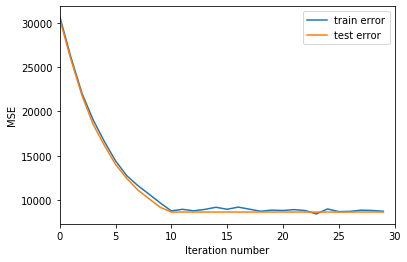

In [142]:
get_error_plot_stochastic(n_trees, train_errors, test_errors)

Вывод - в отличие от обычного бустинга нет практически переобучения